In [1]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Dropout,Flatten,Conv2D,BatchNormalization,MaxPooling2D,Input,GlobalAveragePooling2D,Dense
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from matplotlib import pyplot

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# Residual Block

In [2]:
class Block(Model):
    def __init__(self,input_channels,output_channels,use_conv=False,identity_strides=1):
        super().__init__()
        self.conv1=Conv2D(input_channels,kernel_size=1,strides=identity_strides)
        self.conv2=Conv2D(input_channels,kernel_size=3,strides=1,padding='same')
        self.conv3=Conv2D(output_channels,kernel_size=1,strides=1,padding='same')
        self.conv_identity=None
        if use_conv:
            self.conv_identity=Conv2D(output_channels,kernel_size=1,strides=identity_strides,padding='same')
            
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()
        self.bn3=BatchNormalization()
        self.bn_identity =BatchNormalization()
        
    def call(self,X):
        #Traditional residuals
        Y=self.conv1(X)
        Y = self.bn1(Y)
        Y= relu(Y)
        
        Y=self.conv2(Y)
        Y = self.bn2(Y)
        Y= relu(Y)
        
        Y=self.conv3(Y)
        Y = self.bn3(Y)
        Y= relu(Y)
        
        if self.conv_identity is not None:
            X=self.conv_identity(X)
            X=self.bn_identity(X)
        
        Y+=X
        Y=relu(Y)
        return Y

In [3]:
base_layer = tf.keras.models.Sequential([
    Conv2D(input_shape=(224,224,3),filters=64,kernel_size=7,strides=2,padding='same'),
    BatchNormalization(),
    tf.keras.layers.Activation("relu"),
    MaxPooling2D(pool_size=3, strides=2, padding='same')
    
])
base_layer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization (Batch  (None, 112, 112, 64)      256       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 56, 56, 64)        0         
 D)                                                              
                                                                 
Total params: 9728 (38.00 KB)
Trainable params: 9600 (37.50 KB)
Non-trainable params: 128 (512.00 Byte)
_________________________________________________________________


In [4]:
train_directory='/hymenoptera/hymenoptera/train' # train path
val_directory='/hymenoptera/hymenoptera/val' # validation path

In [5]:
batch_size = 4
epochs = 25
lr = 0.001

In [6]:
train_datagen=ImageDataGenerator(preprocessing_function=preprocess_input, rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
#train_datagen.mean = [123.68, 116.779, 103.939]


train_generator = train_datagen.flow_from_directory(
    directory=train_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary'

)
val_datagen=ImageDataGenerator(preprocessing_function=preprocess_input)
#val_datagen.mean = [123.68, 116.779, 103.939]
valid_generator = val_datagen.flow_from_directory(
    directory=val_directory,
    target_size=(224,224),
    batch_size=batch_size,
    class_mode='binary'
)


Found 244 images belonging to 2 classes.
Found 153 images belonging to 2 classes.


In [7]:
strategy = tf.distribute.MirroredStrategy()

# Resnet 50

In [8]:
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model

def ResNet50(input_shape=(224, 224, 3), input_tensor=None, classes=1000):
    if input_tensor is None:
        X_input = Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            X_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            X_input = input_tensor
            
    X = Conv2D(filters=64, kernel_size=7, strides=2, padding='same')(X_input)
    X = BatchNormalization()(X)
    X = relu(X)
    X = MaxPooling2D(pool_size=3, strides=2, padding='same')(X)

    # Stage 1
    X = Block(64, 256, use_conv=True, identity_strides=1)(X)
    X = Block(256, 256, use_conv=False)(X)
    X = Block(256, 256, use_conv=False)(X)

    # Stage 2
    X = Block(256, 512, use_conv=True, identity_strides=2)(X)
    for _ in range(3):
        X = Block(512, 512, use_conv=False)(X)

    # Stage 3
    X = Block(512, 1024, use_conv=True, identity_strides=2)(X)
    for _ in range(5):
        X = Block(1024, 1024, use_conv=False)(X)

    # Stage 4
    X = Block(1024, 2048, use_conv=True, identity_strides=2)(X)
    for _ in range(2):
        X = Block(2048, 2048, use_conv=False)(X)

    X = GlobalAveragePooling2D()(X)
    X = Dense(classes, activation='softmax')(X)

    model = Model(inputs=X_input, outputs=X, name='ResNet50')
    return model


In [9]:
model = ResNet50(input_shape=(64,64, 3), classes=100)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        9472      
                                                                 
 batch_normalization_1 (Bat  (None, 32, 32, 64)        256       
 chNormalization)                                                
                                                                 
 tf.nn.relu (TFOpLambda)     (None, 32, 32, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 16, 16, 64)        0         
 g2D)                                                            
                                                                 
 block (Block)               (None, 16, 16, 256)       769

In [10]:
len(model.layers)

23

In [11]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 7 == 0 and epoch:
        return lr * 0.1
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)
model.compile(loss='sparse_categorical_crossentropy',optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr,decay=lr/(epochs/0.5)),metrics=['acc'])

In [12]:
def summarize_diagnostics(history):
 # plot loss
 pyplot.subplot(211)
 pyplot.title('Sparse Categorical Crossentropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['acc'], color='blue', label='train')
 pyplot.plot(history.history['val_acc'], color='orange', label='test')
 # save plot to file
 filename = 'output'
 pyplot.savefig('/kaggle/working/'+filename + '_plot.png')
 pyplot.close()

In [13]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=[lr_callback]
)


Epoch 1/25
61/61 [==============================] - 42s 412ms/step - loss: 2.1096 - acc: 0.5082 - val_loss: 9050.6250 - val_acc: 0.4575 - lr: 0.0010
Epoch 2/25
61/61 [==============================] - 24s 386ms/step - loss: 1.0836 - acc: 0.5246 - val_loss: 79.5924 - val_acc: 0.5425 - lr: 0.0010
Epoch 3/25
61/61 [==============================] - 24s 395ms/step - loss: 0.9988 - acc: 0.5287 - val_loss: 63.4584 - val_acc: 0.5425 - lr: 0.0010
Epoch 4/25
61/61 [==============================] - 25s 402ms/step - loss: 0.9105 - acc: 0.5410 - val_loss: 4.5745 - val_acc: 0.6013 - lr: 0.0010
Epoch 5/25
61/61 [==============================] - 25s 411ms/step - loss: 0.7573 - acc: 0.5738 - val_loss: 6.7255 - val_acc: 0.6209 - lr: 0.0010
Epoch 6/25
61/61 [==============================] - 26s 420ms/step - loss: 0.8477 - acc: 0.5943 - val_loss: 1.3820 - val_acc: 0.4706 - lr: 0.0010
Epoch 7/25
61/61 [==============================] - 26s 420ms/step - loss: 0.7677 - acc: 0.5533 - val_loss: 4.7757 - va

In [14]:
history.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])

In [15]:
history.history

{'loss': [2.1095685958862305,
  1.0835610628128052,
  0.9988317489624023,
  0.9105389714241028,
  0.7572972178459167,
  0.8477193713188171,
  0.7677229046821594,
  0.7061004638671875,
  0.6855441331863403,
  0.676444947719574,
  0.6788176894187927,
  0.6669068932533264,
  0.6554160118103027,
  0.6455101370811462,
  0.649883508682251,
  0.6118924021720886,
  0.6355034112930298,
  0.612800121307373,
  0.6263701915740967,
  0.5952010750770569,
  0.6004722714424133,
  0.6461640000343323,
  0.6096609234809875,
  0.6084254384040833,
  0.6037726998329163],
 'acc': [0.5081967115402222,
  0.5245901346206665,
  0.5286885499954224,
  0.5409836173057556,
  0.5737704634666443,
  0.5942623019218445,
  0.5532786846160889,
  0.5491803288459778,
  0.5983606576919556,
  0.6024590134620667,
  0.631147563457489,
  0.6106557250022888,
  0.5901639461517334,
  0.6516393423080444,
  0.6721311211585999,
  0.6721311211585999,
  0.6434426307678223,
  0.6475409865379333,
  0.6475409865379333,
  0.6844262480735779

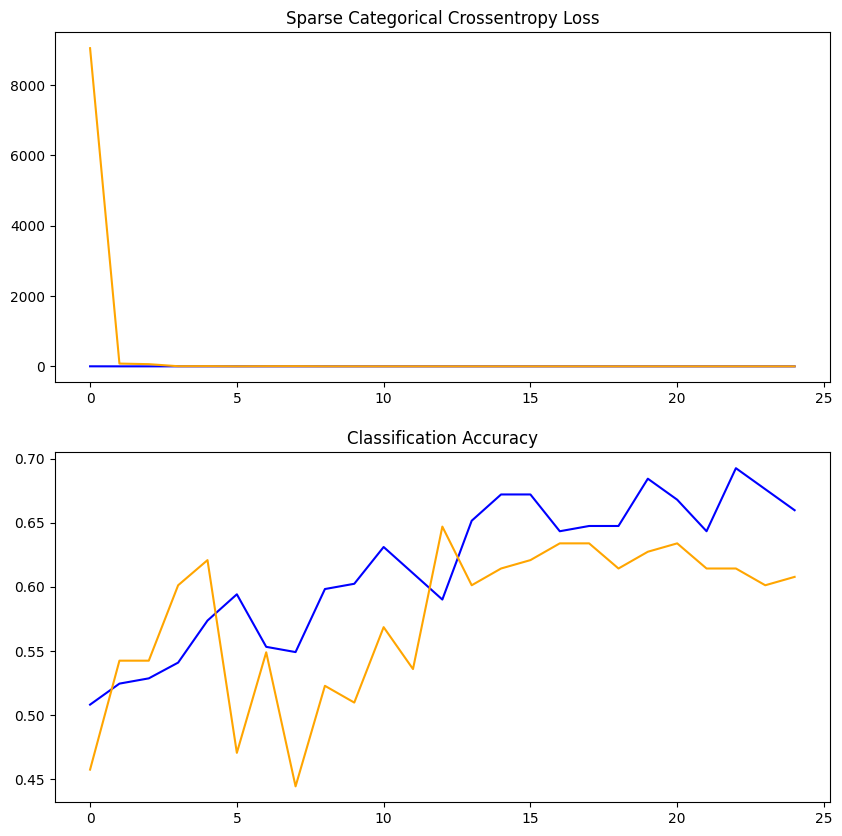

In [16]:
 pyplot.figure(figsize=(10,10))
 pyplot.subplot(211)
 pyplot.title('Sparse Categorical Crossentropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['acc'], color='blue', label='train')
 pyplot.plot(history.history['val_acc'], color='orange', label='test')
 # save plot to file
 filename = 'output1'
 pyplot.savefig('/kaggle/working/'+filename + '_plot.png')
 pyplot.show()

## Transfer learning

In [17]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import LearningRateScheduler
# Load the TensorBoard notebook extension
%load_ext tensorboard
import tensorflow as tf
import datetime

# Data paths
data_dir = '/kaggle/input/hymenoptera/hymenoptera'
train_data_dir = os.path.join(data_dir, 'train')
val_data_dir = os.path.join(data_dir, 'val')

# Data preprocessing
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

val_generator = val_datagen.flow_from_directory(
    val_data_dir,
    target_size=(224, 224),
    batch_size=4,
    class_mode='binary'
)

# Model setup
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
x = Dense(2, activation='softmax')(x)  # New top layer for our task
model = Model(inputs=base_model.input, outputs=x)

# Compile the model
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 7 == 0 and epoch:
        return lr * 0.1
    return lr

lr_callback = LearningRateScheduler(scheduler)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# Train the model
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=val_generator,
    callbacks=[lr_callback]
)


Found 244 images belonging to 2 classes.
Found 153 images belonging to 2 classes.
94765736/94765736 [==============================] - 0s 0us/step
Epoch 1/25
61/61 [==============================] - 10s 103ms/step - loss: 1.7015 - accuracy: 0.8566 - val_loss: 2.3947 - val_accuracy: 0.9281 - lr: 0.0100
Epoch 2/25
61/61 [==============================] - 5s 81ms/step - loss: 1.2940 - accuracy: 0.9139 - val_loss: 1.6644 - val_accuracy: 0.9412 - lr: 0.0100
Epoch 3/25
61/61 [==============================] - 5s 81ms/step - loss: 0.8522 - accuracy: 0.9467 - val_loss: 3.0808 - val_accuracy: 0.9150 - lr: 0.0100
Epoch 4/25
61/61 [==============================] - 5s 82ms/step - loss: 0.6371 - accuracy: 0.9713 - val_loss: 2.3075 - val_accuracy: 0.9281 - lr: 0.0100
Epoch 5/25
61/61 [==============================] - 5s 82ms/step - loss: 0.3961 - accuracy: 0.9590 - val_loss: 1.9076 - val_accuracy: 0.9477 - lr: 0.0100
Epoch 6/25
61/61 [==============================] - 5s 85ms/step - loss: 4.6590e-

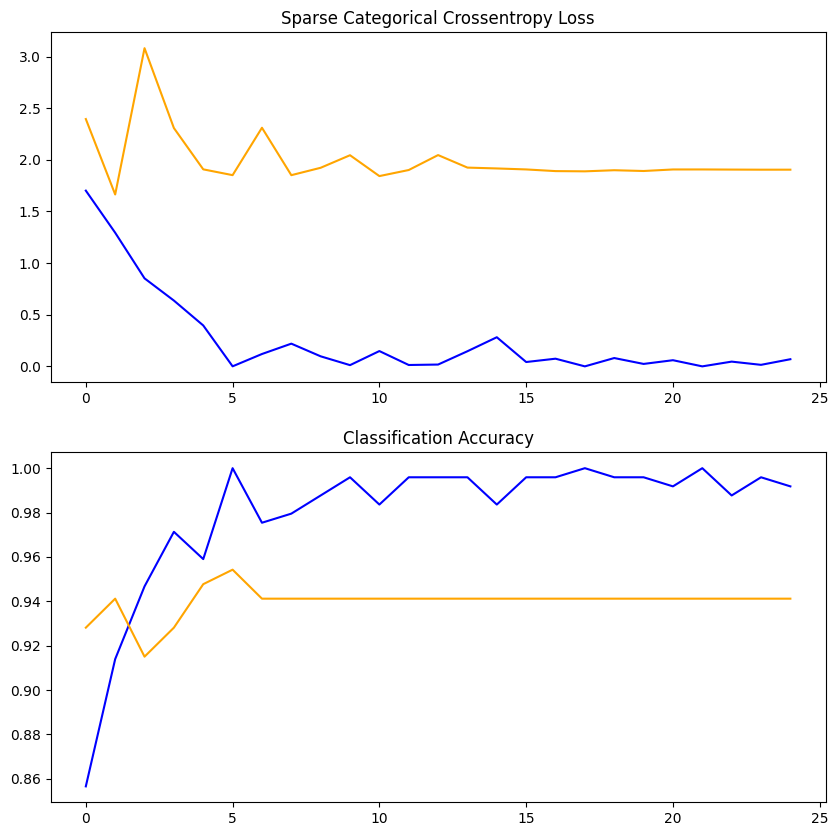

In [18]:
 pyplot.figure(figsize=(10,10))
 pyplot.subplot(211)
 pyplot.title('Sparse Categorical Crossentropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 filename = 'output2'
 pyplot.savefig('/kaggle/working/'+filename + '_plot.png')
 pyplot.show()

In [19]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy', 'lr'])

In [20]:
history.history

{'loss': [1.7014527320861816,
  1.2939790487289429,
  0.8522140383720398,
  0.6370785236358643,
  0.3961315155029297,
  0.00046590069541707635,
  0.11967756599187851,
  0.21993528306484222,
  0.09722109138965607,
  0.011935098096728325,
  0.14822666347026825,
  0.013315136544406414,
  0.017600446939468384,
  0.14658130705356598,
  0.2820262908935547,
  0.042121246457099915,
  0.07428814470767975,
  5.4096249186841305e-06,
  0.08062628656625748,
  0.023654811084270477,
  0.05961674079298973,
  1.207427430927055e-05,
  0.04597144201397896,
  0.014839624986052513,
  0.06921922415494919],
 'accuracy': [0.8565573692321777,
  0.9139344096183777,
  0.9467213153839111,
  0.9713114500045776,
  0.9590163826942444,
  1.0,
  0.9754098653793335,
  0.9795082211494446,
  0.9877049326896667,
  0.9959016442298889,
  0.9836065769195557,
  0.9959016442298889,
  0.9959016442298889,
  0.9959016442298889,
  0.9836065769195557,
  0.9959016442298889,
  0.9959016442298889,
  1.0,
  0.9959016442298889,
  0.9959

In [21]:
# model.save("path/to/location")

/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Revamp

In [23]:
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import Activation, Dropout,Flatten,Conv2D,BatchNormalization,MaxPooling2D,Input,GlobalAveragePooling2D,Dense, AveragePooling2D
from tensorflow.keras.activations import relu
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from tensorflow.keras.applications.resnet50 import preprocess_input
from matplotlib import pyplot

In [24]:
class Block_2(Model):
    def __init__(self,input_channels,output_channels,use_conv=False,identity_strides=1):
        super().__init__()
        self.conv1=Conv2D(input_channels,kernel_size=1,strides=identity_strides)
        self.conv2=Conv2D(input_channels,kernel_size=3,strides=1,padding='same')
        self.conv3=Conv2D(output_channels,kernel_size=1,strides=1,padding='same')
        self.conv_identity=None
        if use_conv:
            self.conv_identity=Conv2D(output_channels,kernel_size=1,strides=identity_strides,padding='same')
            
        self.bn1=BatchNormalization()
        self.bn2=BatchNormalization()
        self.bn3=BatchNormalization()
        self.bn_identity =BatchNormalization()
        
    def call(self,X):
        #Traditional residuals
        Y=self.conv1(X)
        Y = self.bn1(Y)
        Y= relu(Y)
        
        Y=self.conv2(Y)
        Y = self.bn2(Y)
        Y= relu(Y)
        
        Y=self.conv3(Y)
        Y = self.bn3(Y)
        Y= relu(Y)
        
        if self.conv_identity is not None:
            X=self.conv_identity(X)
            X=self.bn_identity(X)
        
        Y+=X
        Y=relu(Y)
        return Y

In [25]:
from tensorflow.keras import backend
from tensorflow.keras import optimizers, losses, initializers
from tensorflow.keras.activations import relu
def ResNet50_2(input_shape=(224, 224, 3), input_tensor=None,classes=1000):
    if input_tensor is None:
        X_input = Input(shape=input_shape)
    else:
        if not backend.is_keras_tensor(input_tensor):
            X_input = Input(tensor=input_tensor, shape=input_shape)
        else:
            X_input = input_tensor
    #Stage1        
    X=Conv2D(filters=64,kernel_size=7,strides=2,padding='same')(X_input)
    X= BatchNormalization()(X)
    X=relu(X)
    X= MaxPooling2D(pool_size=3, strides=2, padding='same')(X)
    
    #Stage2
    X=Block_2(64,256,True,1)(X)
    X=Block_2(64,256,False)(X)
    X=Block_2(64,256,False)(X)
    
    #Stage3
    X=Block_2(128,512,True,2)(X)
    X=Block_2(128,512,False)(X)
    X=Block_2(128,512,False)(X)
    
    #Stage4
    X=Block_2(256,1024,True,2)(X)
    X=Block_2(256,1024,False)(X)
    X=Block_2(256,1024,False)(X)
    X=Block_2(256,1024,False)(X)
    X=Block_2(256,1024,False)(X)
    X=Block_2(256,1024,False)(X)
    
    #Stage5
    X=Block_2(512,2048,True,2)(X)
    X=Block_2(512,2048,False)(X)
    X=Block_2(512,2048,False)(X)
    
    
    X=AveragePooling2D((2, 2))(X)
    X = Flatten()(X)
    
    #Fully-Connected
    X=Dense(classes,activation='softmax')(X)

    model = Model(inputs = X_input, outputs = X, name='ResNet50')
    return model

In [26]:
model = ResNet50_2(input_shape=(224,224, 3), classes=2)
model.summary()

Model: "ResNet50"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv2d_54 (Conv2D)          (None, 112, 112, 64)      9472      
                                                                 
 batch_normalization_66 (Ba  (None, 112, 112, 64)      256       
 tchNormalization)                                               
                                                                 
 tf.nn.relu_1 (TFOpLambda)   (None, 112, 112, 64)      0         
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 56, 56, 64)        0         
 g2D)                                                            
                                                                 
 block_2 (Block_2)           (None, 56, 56, 256)       769

In [27]:
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch % 7 == 0 and epoch:
        return lr * 0.1
    return lr

lr_callback = keras.callbacks.LearningRateScheduler(scheduler)
model.compile(optimizer=SGD(lr=0.001, momentum=0.9),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [28]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=[lr_callback]
)


Epoch 1/25
61/61 [==============================] - 21s 105ms/step - loss: 104.2189 - accuracy: 0.4385 - val_loss: 79021391872.0000 - val_accuracy: 0.5425 - lr: 0.0100
Epoch 2/25
61/61 [==============================] - 5s 87ms/step - loss: 38.1477 - accuracy: 0.4918 - val_loss: 133302.2500 - val_accuracy: 0.5359 - lr: 0.0100
Epoch 3/25
61/61 [==============================] - 5s 87ms/step - loss: 8.9450 - accuracy: 0.4467 - val_loss: 1197.6130 - val_accuracy: 0.5686 - lr: 0.0100
Epoch 4/25
61/61 [==============================] - 5s 85ms/step - loss: 5.3071 - accuracy: 0.4877 - val_loss: 606.2255 - val_accuracy: 0.5033 - lr: 0.0100
Epoch 5/25
61/61 [==============================] - 5s 86ms/step - loss: 4.6094 - accuracy: 0.5164 - val_loss: 8.9446 - val_accuracy: 0.5490 - lr: 0.0100
Epoch 6/25
61/61 [==============================] - 5s 88ms/step - loss: 2.3121 - accuracy: 0.5246 - val_loss: 9.3914 - val_accuracy: 0.4837 - lr: 0.0100
Epoch 7/25
61/61 [==============================] -

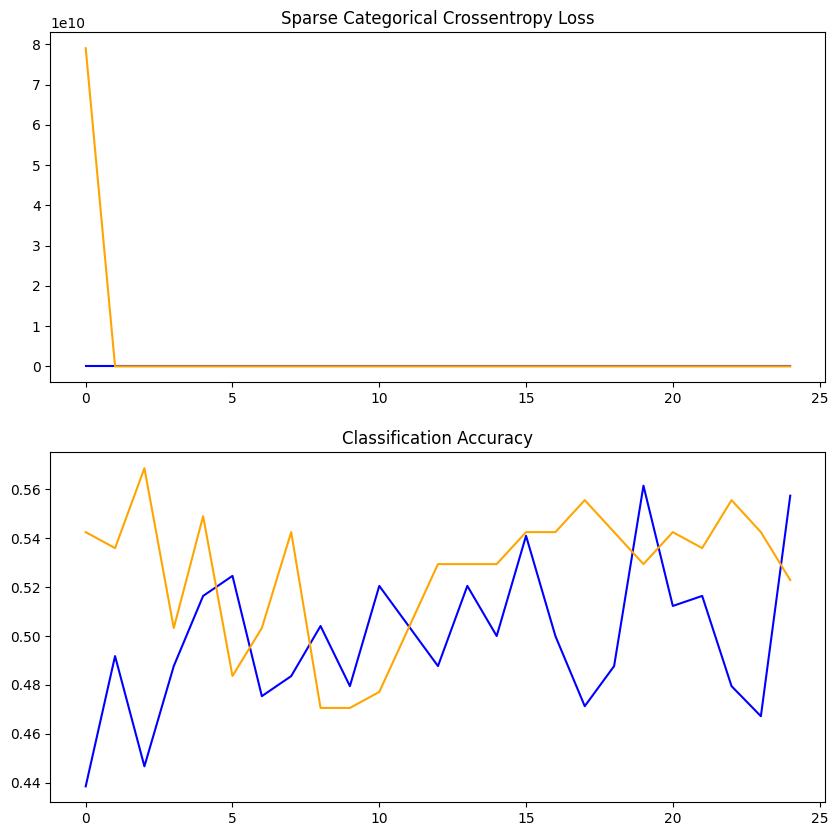

In [29]:
 pyplot.figure(figsize=(10,10))
 pyplot.subplot(211)
 pyplot.title('Sparse Categorical Crossentropy Loss')
 pyplot.plot(history.history['loss'], color='blue', label='train')
 pyplot.plot(history.history['val_loss'], color='orange', label='test')
 # plot accuracy
 pyplot.subplot(212)
 pyplot.title('Classification Accuracy')
 pyplot.plot(history.history['accuracy'], color='blue', label='train')
 pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
 # save plot to file
 filename = 'output2'
 pyplot.savefig('/kaggle/working/'+filename + '_plot.png')
 pyplot.show()

In [30]:
history = model.fit(
    train_generator,
    epochs=25,
    validation_data=valid_generator,
    callbacks=[lr_callback]
)

Epoch 1/25
61/61 [==============================] - 5s 88ms/step - loss: 0.7873 - accuracy: 0.5082 - val_loss: 2.0235 - val_accuracy: 0.5359 - lr: 1.0000e-05
Epoch 2/25
61/61 [==============================] - 5s 84ms/step - loss: 0.7902 - accuracy: 0.4918 - val_loss: 2.0236 - val_accuracy: 0.5229 - lr: 1.0000e-05
Epoch 3/25
61/61 [==============================] - 5s 85ms/step - loss: 0.7534 - accuracy: 0.5164 - val_loss: 2.0301 - val_accuracy: 0.5359 - lr: 1.0000e-05
Epoch 4/25
61/61 [==============================] - 5s 90ms/step - loss: 0.7164 - accuracy: 0.4959 - val_loss: 2.1514 - val_accuracy: 0.5229 - lr: 1.0000e-05
Epoch 5/25
61/61 [==============================] - 5s 87ms/step - loss: 0.8259 - accuracy: 0.5164 - val_loss: 2.0575 - val_accuracy: 0.5098 - lr: 1.0000e-05
Epoch 6/25
61/61 [==============================] - 5s 86ms/step - loss: 0.8372 - accuracy: 0.5205 - val_loss: 2.0441 - val_accuracy: 0.5359 - lr: 1.0000e-05
Epoch 7/25
61/61 [==============================] - 

In [31]:
history.history

{'loss': [0.7872961759567261,
  0.7901881337165833,
  0.7533836960792542,
  0.7164063453674316,
  0.8258869647979736,
  0.8371686339378357,
  0.7949627041816711,
  0.7801616191864014,
  0.769418478012085,
  0.8481940627098083,
  0.7691701650619507,
  0.9030331373214722,
  0.8487513661384583,
  0.7566442489624023,
  0.7702319622039795,
  0.8182047009468079,
  0.798949122428894,
  0.844809353351593,
  0.7768710851669312,
  0.8871915340423584,
  0.808044970035553,
  0.7975834012031555,
  0.810073733329773,
  0.7706983685493469,
  0.7700796127319336],
 'accuracy': [0.5081967115402222,
  0.49180328845977783,
  0.5163934230804443,
  0.4959016442298889,
  0.5163934230804443,
  0.5204917788505554,
  0.5286885499954224,
  0.5,
  0.5122950673103333,
  0.5122950673103333,
  0.46311476826667786,
  0.5163934230804443,
  0.4959016442298889,
  0.5204917788505554,
  0.4836065471172333,
  0.5122950673103333,
  0.43852460384368896,
  0.5081967115402222,
  0.5081967115402222,
  0.5163934230804443,
  0.46

# Make the prediction from trainded model

In [ ]:
dic=train_generator.class_indices
icd={k:v for v,k in dic.items()}

# make a prediction for a new image.
from keras.utils import load_img
from keras.utils import img_to_array
from keras.models import load_model
from matplotlib import pyplot as plt
import numpy as np

# load and prepare the image
def load_image(filename):
    # load the image
    img = load_img(filename, target_size=(224, 224))
    plt.imshow(img)
    # convert to array
    img = img_to_array(img)
    img = img.reshape(1, 224, 224, 3)
    # center pixel data
    img = img.astype('float32')
    img = img/255.0
    return img

# load an image and predict the class
def predict_print():
    # load the image
    img = load_image('test/WILLOW PTARMIGAN/5.jpg')
    # load model
    model = load_model('models/ant-bee-25epochs.h5', custom_objects={'Block': Block})
    # predict the class
    result = model.predict(img)
    print(icd[result[0].tolist().index(max(result[0]))])    
# entry point, run the example

predict_print()